# Modelos estatísticos
Neste notebook tem os seguintes modelos estatísticos:
- AR
- ARIMA
- SARIMA

## Importações

In [29]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# autoarima
import pmdarima as pm

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

## Preparação do Diretório Principal

In [30]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [31]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Formatação das células

In [32]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Carregamento dos dados

In [34]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                              encoding='utf8',
                              delimiter=',',
                              parse_dates=True,
                              index_col=0,
                              verbose=True)

Tokenization took: 2.10 ms
Type conversion took: 2.88 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 14.6 ms, sys: 635 µs, total: 15.2 ms
Wall time: 14 ms


In [35]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.000000,1.002310,41.827333,1.000149,-0.600000,-0.460000,0.490000,0.980000,0.420000
2010-07-13,40.070000,1.036654,41.910833,0.998563,0.070000,-0.530000,-0.390000,0.560000,1.050000
2010-07-14,40.080000,1.028377,41.977833,1.000439,0.010000,0.080000,-0.520000,-0.380000,0.570000
2010-07-15,39.760000,1.044658,42.045833,1.000935,-0.320000,-0.310000,-0.240000,-0.840000,-0.700000
2010-07-16,38.880000,1.028132,42.123500,1.001784,-0.880000,-1.200000,-1.190000,-1.120000,-1.720000


---

## Divisão dos Dados

In [36]:
size_train = 2415
size_test = 30
print(size_train)
print(size_test)

df_train = df_vale3['preco'].iloc[:size_train]
df_test = df_vale3['preco'].iloc[size_train:]

2415
30


In [37]:
df_train.tail()

data
2020-04-07   43.780000
2020-04-08   43.510000
2020-04-09   43.280000
2020-04-13   44.570000
2020-04-14   44.530000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Treinamento = 2415')

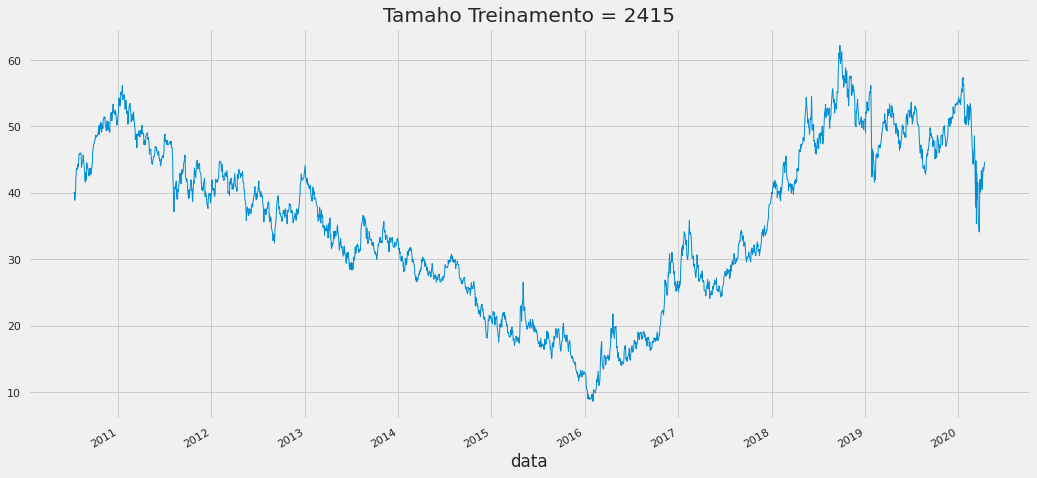

In [38]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Treinamento = {len(df_train)}')

In [39]:
df_test.head()

data
2020-04-15   43.190000
2020-04-16   42.760000
2020-04-17   44.000000
2020-04-20   42.460000
2020-04-22   42.900000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Teste = 30')

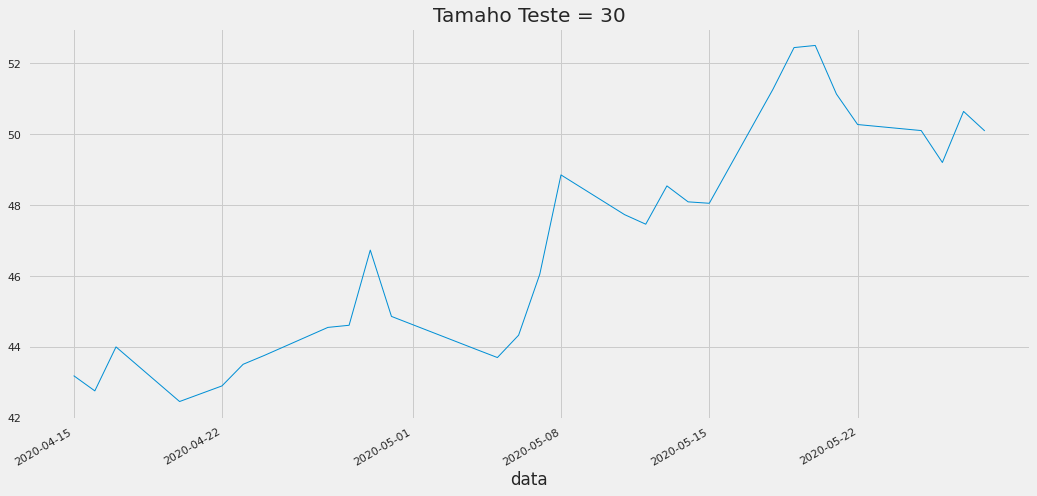

In [40]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Teste = {len(df_test)}')

### Manipulação do índice

In [41]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-13', '2020-04-14'],
              dtype='datetime64[ns]', name='data', length=2415, freq=None)

In [42]:
df_test.index

DatetimeIndex(['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-20',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', freq=None)

In [43]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=2415, step=1)

In [44]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=30, step=1)

In [45]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=2415, step=1)

In [46]:
df_test.index = pd.RangeIndex(start=2415, stop=len(df_vale3), step=1)
df_test.index

RangeIndex(start=2415, stop=2445, step=1)

---

## Métrica de Avaliação

In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---

## Dicionário de Resultados

In [48]:
dict_results = {}

---

## Impressão dos Resutados

In [49]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    mape = mean_absolute_percentage_error(df_test, y_forecast)
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## Busca dos Melhores Parâmetros

#### Grid Search

In [50]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [51]:
def search_best_params_arima_model(df_train: 'Dataframe', pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()
    
    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')
            
            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except: 
            continue
    
    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [52]:
def search_best_params_sarima_model(df_train, trend, pdq):  
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()
    
    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,          
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except: 
            continue
    
    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

---

## **Modelos Estatísticos**

## AR
- A ST não é estacionária
- Não há tendência, (trend='n')
- Não aá sazonalidade, (seasonal=False) no período de 30 dias

In [53]:
ar_model = AutoReg(df_train,
                   lags=30,
                   trend='n',
                   seasonal=False,
                   period=len(df_test))
ar_fit = ar_model.fit()

In [54]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

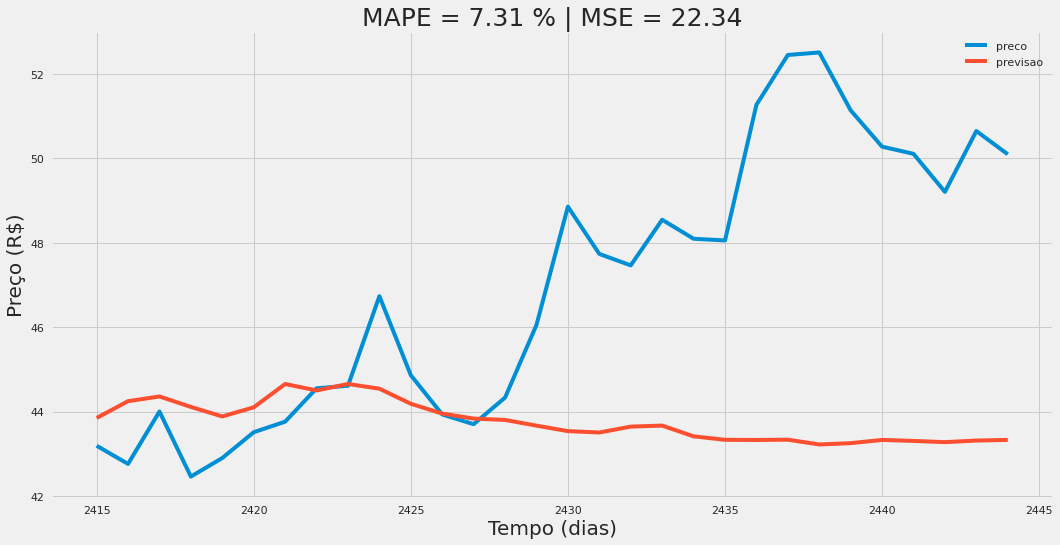

In [55]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

#### zoom

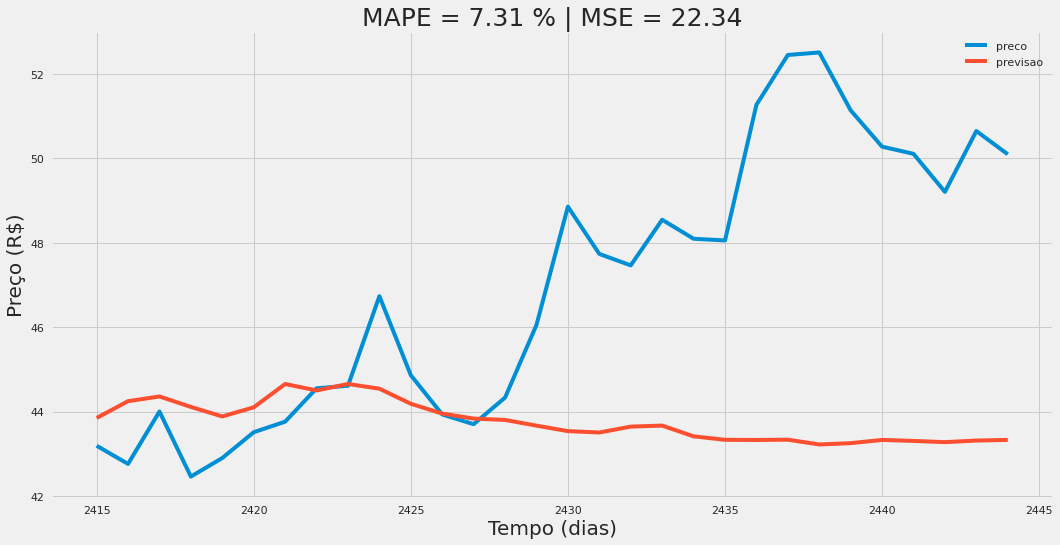

In [56]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

---

### ARIMA

## Librarie: `pmdarima`
- Tips: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [57]:
%%time

list_order_arima = search_best_params_arima_model(df_train=df_train,
                                                  pdq=list_pdq)
print(list_order_arima)

pdq = (0, 0, 0) | AIC = 18974.159932736322
pdq = (0, 0, 1) | AIC = 15847.637275064231
pdq = (0, 0, 2) | AIC = 13561.154466403974
pdq = (0, 1, 0) | AIC = 6352.768252799672
pdq = (0, 1, 1) | AIC = 6350.524624394297
pdq = (0, 1, 2) | AIC = 6340.313542113301
pdq = (0, 2, 0) | AIC = 8115.886934606986
pdq = (0, 2, 1) | AIC = 6360.642759046002
pdq = (0, 2, 2) | AIC = 6359.287622193227
pdq = (1, 0, 0) | AIC = 6358.62505633127
pdq = (1, 0, 1) | AIC = 6356.660857064225
pdq = (1, 0, 2) | AIC = 6346.8611580606375
pdq = (1, 1, 0) | AIC = 6351.105797529564
pdq = (1, 1, 1) | AIC = 6343.033761417953
pdq = (1, 1, 2) | AIC = 6336.2914261760225
pdq = (1, 2, 0) | AIC = 7467.9662234387815
pdq = (1, 2, 1) | AIC = 6359.034728262
pdq = (2, 0, 0) | AIC = 6357.196557476122
pdq = (2, 0, 1) | AIC = 6349.8852699168365
pdq = (2, 0, 2) | AIC = 6342.645188065021
pdq = (2, 1, 0) | AIC = 6341.3047553815495
pdq = (2, 1, 1) | AIC = 6337.075186435318
pdq = (2, 2, 0) | AIC = 7092.466407612979
pdq = (2, 2, 1) | AIC = 6349.3

In [58]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=1,
                                start_d=1,
                                start_q=2,
                                max_p=30,
                                max_d=30,
                                max_q=30,
                                # trend=False,
                                seasonal=False,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6336.291, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6352.768, Time=0.84 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6351.106, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6350.525, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6350.779, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6340.314, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6343.034, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6335.575, Time=2.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6337.075, Time=1.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6336.166, Time=1.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6334.093, Time=3.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6337.673, Time=1.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6336.181, Time=2.87 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=6337.758, Time=4.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

In [59]:
print(autoarima_model.order)
print(autoarima_model.aic())

(3, 1, 4)
6319.39685000518


In [60]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [61]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test[:50]))
len(y_forecast)

30

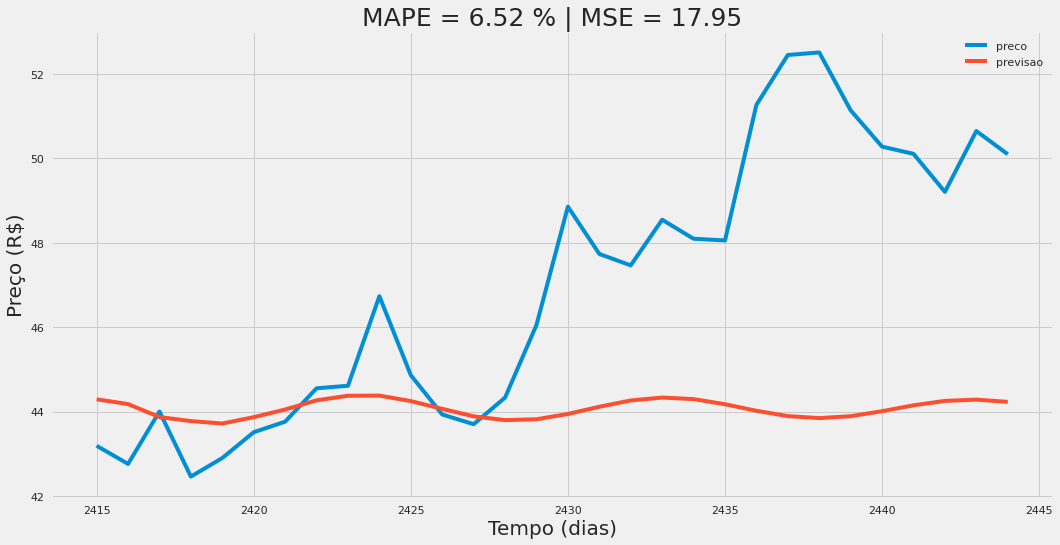

In [62]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model')

#### Zoom

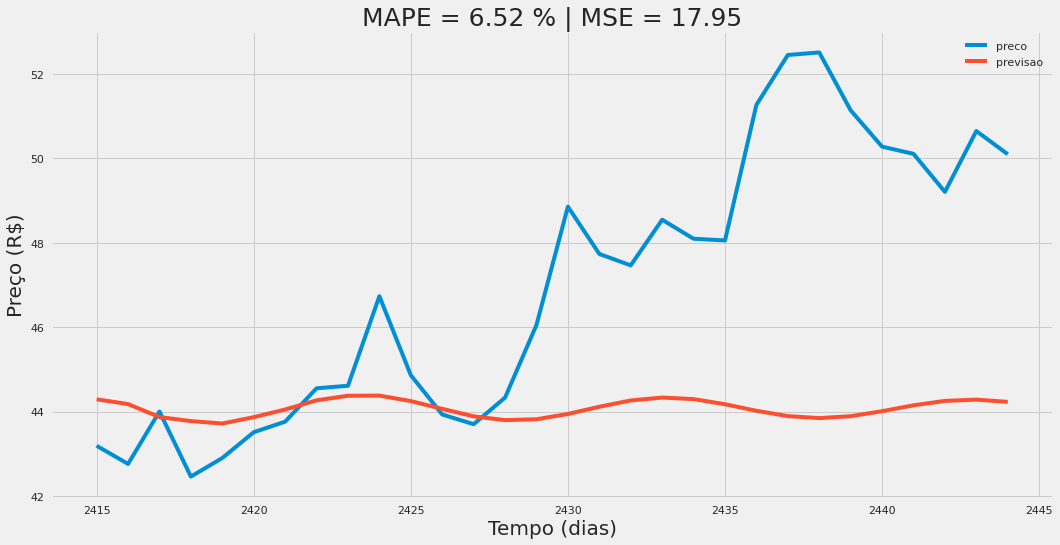

In [63]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_forecast,
                  model_name='arima_model')

---

## **SARIMA**

In [64]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train,
                                                          trend='t',
                                                          pdq=(3, 1, 3))
print(list_order_seasonal_aic)

pdq = (3, 1, 3) | param_seasonal = (0, 0, 0, 12) | AIC = 6339.124621859275
pdq = (3, 1, 3) | param_seasonal = (0, 0, 1, 12) | AIC = 6338.031419311456
pdq = (3, 1, 3) | param_seasonal = (0, 0, 2, 12) | AIC = 6336.018124144093
pdq = (3, 1, 3) | param_seasonal = (0, 1, 0, 12) | AIC = 8059.09988429914
pdq = (3, 1, 3) | param_seasonal = (0, 1, 1, 12) | AIC = 7004.804412774307
pdq = (3, 1, 3) | param_seasonal = (0, 1, 2, 12) | AIC = 6912.811466815344
pdq = (3, 1, 3) | param_seasonal = (0, 2, 0, 12) | AIC = 10631.931835186979
pdq = (3, 1, 3) | param_seasonal = (0, 2, 1, 12) | AIC = 9840.03632141267
pdq = (3, 1, 3) | param_seasonal = (0, 2, 2, 12) | AIC = 8910.811939479154
pdq = (3, 1, 3) | param_seasonal = (1, 0, 0, 12) | AIC = 6338.128198280105
pdq = (3, 1, 3) | param_seasonal = (1, 0, 1, 12) | AIC = 6335.981000287489
pdq = (3, 1, 3) | param_seasonal = (1, 0, 2, 12) | AIC = 6336.456711085466
pdq = (3, 1, 3) | param_seasonal = (1, 1, 0, 12) | AIC = 7440.089436402188
pdq = (3, 1, 3) | param_se

In [65]:
list_order_seasonal_aic

[(2, 0, 1, 12), 6335.857132528785]

In [66]:
# autosarima_model = pm.auto_arima(df_train,
#                                 stepwise=True,
#                                 suppress_warnings=True,
#                                 error_action="ignore",
#                                 information_criterion='aic',
#                                 start_p=3,
#                                 start_d=1,
#                                 start_q=3,
#                                 max_p=30,
#                                 max_d=30,
#                                 max_q=30,
#                                 seasonal=True, 
#                                 stationary=False,
#                                 trace=True)

In [67]:
sarima_model = SARIMAX(df_train,
                       order=(6, 2, 6),
                       seasonal_order=list_order_seasonal_aic[0],
                       trend='c',          
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [68]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

In [69]:

# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1])
print(len(y_forecast_sarima))

30


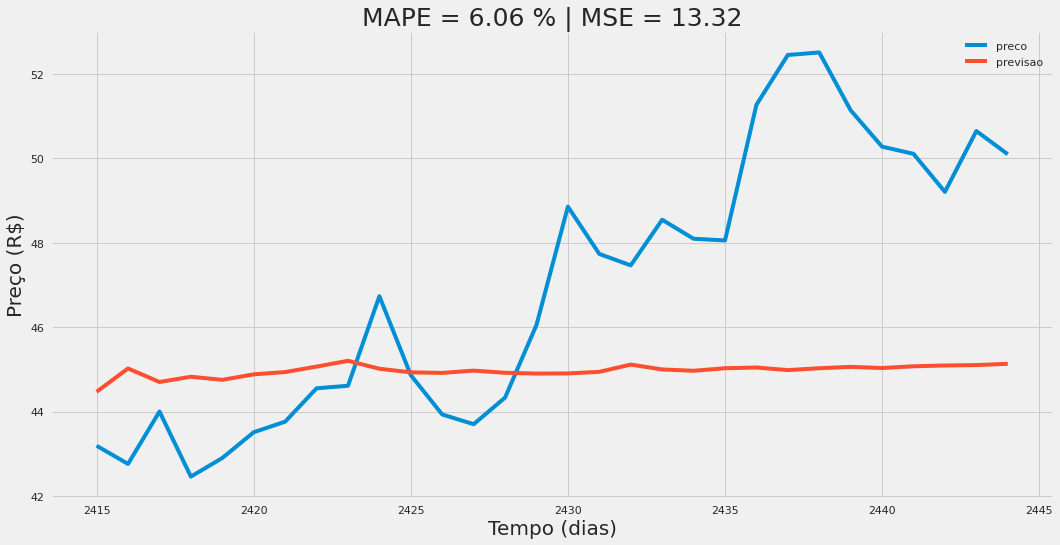

In [70]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

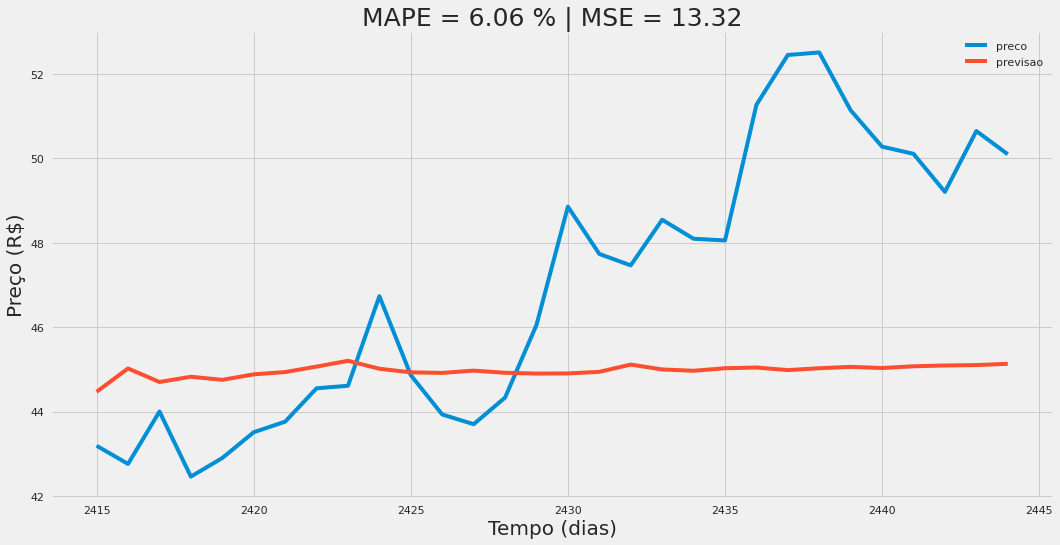

In [71]:
show_result_model(df_train=df_test,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

---

## Resultados

In [72]:
dict_results

{'ar_model': [7.305621439008979, 22.343211526143307],
 'arima_model': [6.523541924668703, 17.950380032175307],
 'sarima_model': [6.063893351025526, 13.322516952460289]}

---